In [1]:
from somajo import SoMaJo
import random
import time
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from lxml.etree import iterparse
from xml.etree import ElementTree
import re
from multiprocessing import Pool
import string
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import layers, models

import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

from fastai.train import Learner, DataBunch

sns.set()

In [2]:
device = torch.device("cpu")
device

device(type='cpu')

In [3]:
REMOVE_DOT_CHANCE = 0.5
LOWERCASE_START_CHANCE = 0.5
MIN_LENGTH = 600
N_CUTS = 4
CUT_LENGTH = 100

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(127 + 2, 25)
        self.lstm1 = nn.LSTM(25, 50, bidirectional=True, batch_first=True, bias=False)
        self.lstm2 = nn.LSTM(100, 50, bidirectional=True, batch_first=True, bias=False)
        self.out = nn.Linear(100, 2)
    
    def get_keras_equivalent(self):
        k_model = models.Sequential()
        k_model.add(layers.Input(shape=(None,)))
        
        k_model.add(layers.Embedding(127 + 2, 25))
        k_model.layers[-1].set_weights([self.embedding.weight.detach().cpu().numpy()])
        
        k_model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, use_bias=False)))
        k_model.layers[-1].set_weights([np.transpose(x.detach().cpu().numpy()) for x in self.lstm1.parameters()])
                
        k_model.add(layers.Bidirectional(layers.LSTM(50, return_sequences=True, use_bias=False)))
        k_model.layers[-1].set_weights([np.transpose(x.detach().cpu().numpy()) for x in self.lstm2.parameters()])
        
        k_model.add(layers.Dense(2))
        k_model.layers[-1].set_weights([np.transpose(x.detach().cpu().numpy()) for x in self.out.parameters()])
        return k_model
        
    def forward(self, x):
        h = self.embedding(x.long())
        h, _ = self.lstm1(h)
        h, _ = self.lstm2(h)
        h = self.out(h)
        return h

# Data

In [10]:
tokenizer = SoMaJo("de_CMC", split_camel_case=True, split_sentences=True)

def split_func(paragraph):
    return tokenizer.tokenize_text([paragraph])
    
def text_to_id(char):
    x = ord(char)
    return x + 2 if x <= 127 else 1
    
def id_to_text(x):
    return chr(x - 2) if (x - 2) <= 127 and x > 1 else "X"
    
def generate_data(paragraph):
    if len(paragraph) < MIN_LENGTH:
        return [], []
    
    p_text, p_labels = paragraph_to_io(paragraph)
    assert len(p_text) == len(p_labels)
    
    inputs = [[] for _ in range(N_CUTS)]
    labels = [[] for _ in range(N_CUTS)]
    
    for j in range(N_CUTS):
        start = random.randint(0, len(p_text))
        
        for k in range(CUT_LENGTH):
            if start + k >= len(p_text):
                inputs[j].append(0)
                labels[j].append([0.0, 0.0])
            else:
                inputs[j].append(text_to_id(p_text[start + k]))
                labels[j].append(p_labels[start + k])
    
    return inputs, labels
    
def paragraph_to_io(paragraph):
    tokenized_p = split_func(paragraph)
    
    text = ""
    labels = []
    
    for sentence in tokenized_p:
        for i, token in enumerate(sentence):
            whitespace = " " if token.space_after else ""
            text_to_append = token.text + whitespace

            if token.text == "." and i == len(sentence) - 1 and random.random() < REMOVE_DOT_CHANCE:
                text_to_append = whitespace
                if len(text_to_append) > 0 and len(labels) > 1:
                    labels[-2][0] = 0.0

            if i == 0 and random.random() < LOWERCASE_START_CHANCE:
                text_to_append = token.text.lower() + whitespace

            for _ in range(len(text_to_append)):
                labels.append([0.0, 0.0])
            
            if len(labels) > 0:
                labels[-1][0] = 1.0
                
            text += text_to_append
        
        labels[-1][1] = 1.0
        
    return text, labels

In [11]:
def fast_iter(context):
    for event, elem in context:
        text = ElementTree.tostring(elem, encoding="utf8").decode("utf-8")
        text = re.sub(r"(<h>(.*?)<\/h>)", "\n", text)
        text = re.sub(r"<.*?>", "", text)
        yield text

        # It's safe to call clear() here because no descendants will be
        # accessed
        elem.clear()
        # Also eliminate now-empty references from the root node to elem
        for ancestor in elem.xpath("ancestor-or-self::*"):
            while ancestor.getprevious() is not None:
                parent = ancestor.getparent()

                if parent is not None:
                    del parent[0]
                else:
                    break

In [12]:
MAX_N_TEXTS = 100
all_texts = np.zeros([MAX_N_TEXTS, CUT_LENGTH], dtype=np.int64)
all_labels = np.zeros([MAX_N_TEXTS, CUT_LENGTH, 2], dtype=np.float32)

bar = tqdm(total=MAX_N_TEXTS)

i = 0
for paragraph in fast_iter(iterparse("data/sample-monolingual.xml", tag="p")):
    text, labels = generate_data(paragraph)
    
    length = min(len(text), MAX_N_TEXTS - i)
    
    if length > 0:
        all_texts[i:i+length] = text[:length]
        all_labels[i:i+length] = labels[:length]
    
    i = i + length
    
    if i == MAX_N_TEXTS:
        break
    
    bar.update(length)
    
if i < MAX_N_TEXTS:
    all_texts = all_texts[:i]
    all_labels = all_labels[:i]

In [13]:
np.save("all_texts.npy", all_texts)
np.save("all_labels.npy", all_labels)

In [14]:
all_texts = np.load("all_texts.npy")
all_labels = np.load("all_labels.npy")

In [15]:
n = 1
sample_chars = ''.join([id_to_text(x) for x in all_texts[n].tolist()])
sample_label = all_labels[n].tolist()

for char, l in zip(sample_chars, sample_label):
    print(char, l)

g [0.0, 0.0]
  [1.0, 0.0]
t [0.0, 0.0]
h [0.0, 0.0]
e [0.0, 0.0]
i [0.0, 0.0]
r [0.0, 0.0]
  [1.0, 0.0]
n [0.0, 0.0]
a [0.0, 0.0]
m [0.0, 0.0]
e [1.0, 0.0]
, [0.0, 0.0]
  [1.0, 0.0]
s [0.0, 0.0]
u [0.0, 0.0]
c [0.0, 0.0]
h [0.0, 0.0]
  [1.0, 0.0]
a [0.0, 0.0]
s [0.0, 0.0]
  [1.0, 0.0]
t [0.0, 0.0]
h [0.0, 0.0]
e [0.0, 0.0]
  [1.0, 0.0]
J [0.0, 0.0]
a [0.0, 0.0]
v [0.0, 0.0]
a [0.0, 0.0]
  [1.0, 0.0]
s [0.0, 0.0]
p [0.0, 0.0]
a [0.0, 0.0]
r [0.0, 0.0]
r [0.0, 0.0]
o [0.0, 0.0]
w [0.0, 0.0]
  [1.0, 0.0]
o [0.0, 0.0]
f [0.0, 0.0]
  [1.0, 0.0]
t [0.0, 0.0]
h [0.0, 0.0]
e [0.0, 0.0]
  [1.0, 0.0]
f [0.0, 0.0]
a [0.0, 0.0]
m [0.0, 0.0]
i [0.0, 0.0]
l [0.0, 0.0]
y [0.0, 0.0]
  [1.0, 0.0]
E [0.0, 0.0]
s [0.0, 0.0]
t [0.0, 0.0]
r [0.0, 0.0]
i [0.0, 0.0]
l [0.0, 0.0]
d [0.0, 0.0]
i [0.0, 0.0]
d [0.0, 0.0]
a [0.0, 0.0]
e [1.0, 0.0]
. [0.0, 0.0]
  [1.0, 1.0]
m [0.0, 0.0]
a [0.0, 0.0]
n [0.0, 0.0]
y [0.0, 0.0]
  [1.0, 0.0]
s [0.0, 0.0]
p [0.0, 0.0]
e [0.0, 0.0]
c [0.0, 0.0]
i [0.0, 0.0]
e [0.0, 0.0]

# Model

In [16]:
valid_percent = 0.1
n_valid = int(len(all_texts) * valid_percent)

permutation = np.random.permutation(np.arange(len(all_texts)))
valid_idx, train_idx = permutation[:n_valid], permutation[n_valid:]

In [17]:
all_texts_tensor = torch.from_numpy(all_texts)
all_labels_tensor = torch.from_numpy(all_labels)

train_dataset = data.TensorDataset(all_texts_tensor[train_idx], all_labels_tensor[train_idx])
valid_dataset = data.TensorDataset(all_texts_tensor[valid_idx], all_labels_tensor[valid_idx])

In [18]:
def loss(inputs, targets):
    return F.binary_cross_entropy_with_logits(inputs, targets.float())

In [19]:
batch_size = 128

model = Network()

train_loader = data.DataLoader(train_dataset,
                               batch_size=batch_size, 
                               shuffle=True,
                               pin_memory=False)
valid_loader = data.DataLoader(valid_dataset, 
                               batch_size=batch_size, 
                               shuffle=False,
                               pin_memory=False)

databunch = DataBunch(train_dl=train_loader, valid_dl=valid_loader)
learn = Learner(databunch, model, loss_func=loss)
learn

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f6cbaee0790>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f6cbaee0b50>;

Test: None, model=Network(
  (embedding): Embedding(129, 25)
  (lstm1): LSTM(25, 50, bias=False, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, bias=False, batch_first=True, bidirectional=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function loss at 0x7f6cbaf683b0>, metrics=[], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)], callbacks=[], layer_groups=[Sequential(
  (0): Embedding(129, 25)
  (1): LSTM(25, 50, bias=False, batch_first=True, bidirectional=True)
  (2): LSTM(100, 50, bias=False, batch_first=True, bidirectional=True)
  (3): Linear(i

In [20]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.707584,0.706329,00:00


In [21]:
learn.save(Path("learn").resolve())

In [13]:
learn = learn.load(Path("learn").resolve())

In [22]:
preds, targets = learn.get_preds()
preds = preds.reshape((-1, 2))
targets = targets.reshape((-1, 2))

In [23]:
token_preds = preds[:, 0]
token_targets = targets[:, 0]

sentence_preds = preds[:, 1]
sentence_targets = targets[:, 1]

t_precision, t_recall, t_thresholds = metrics.precision_recall_curve(token_targets, token_preds)
s_precision, s_recall, s_thresholds = metrics.precision_recall_curve(sentence_targets, sentence_preds)

Text(0.5, 1.0, 'Precision vs Recall of Sentencizer')

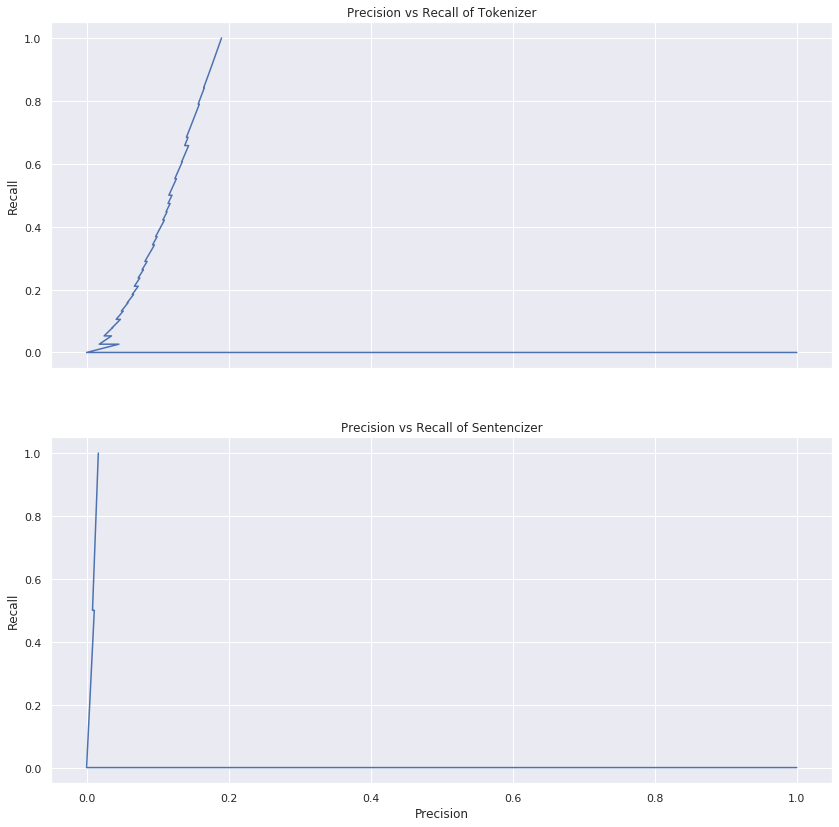

In [24]:
fig, axarr = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
axarr[0].plot(t_precision, t_recall)
axarr[0].set_title("Precision vs Recall of Tokenizer")
axarr[0].set_ylabel("Recall")
axarr[1].plot(s_precision, s_recall)
axarr[1].set_ylabel("Recall")
axarr[1].set_xlabel("Precision")
axarr[1].set_title("Precision vs Recall of Sentencizer")

In [25]:
stride = 90

def predict(text, threshold=0.5):
    all_inputs = []
    all_idx = []
    
    inputs = [text_to_id(x) for x in text]
    
    while len(inputs) < CUT_LENGTH:
        inputs.append(0)
    
    n_preds = np.zeros(len(inputs))
    
    start = 0
    end = -1
    while end != len(inputs):
        end = min(start + CUT_LENGTH, len(inputs))
        start = end - CUT_LENGTH
        
        idx = slice(start, end)
        all_inputs.append(inputs[idx])
        all_idx.append(idx)
        
        n_preds[idx] += 1
        
        start += stride
    
    batched_inputs = torch.tensor(all_inputs, device=device, dtype=torch.int64)
    preds = torch.sigmoid(model(batched_inputs).detach().cpu()).numpy()
    
    avg_preds = np.zeros((len(inputs), 2))
    
    for pred, idx in zip(preds, all_idx):
        avg_preds[idx] += pred
        
    avg_preds /= n_preds[:, None]
    
    sentences = []
    tokens = []
    token = ""
    
    for char, pred in zip(text, avg_preds):
        token += char
        
        if pred[0] > threshold:
            tokens.append(token)
            token = ""
    
        if pred[1] > threshold:
            sentences.append(tokens)
            tokens = []
    
    if len(token) > 0:
        tokens.append(token)
    
    if len(tokens) > 0:
        sentences.append(tokens)
    
    return sentences

def predict_somajo(text):
    somajo_sentences = tokenizer.tokenize_text([text])

    sentences = []
    
    for sentence in somajo_sentences:
        tokens = []
    
        for token in sentence:
            tokens.append(token.text + (" " if token.space_after else ""))

        sentences.append(tokens)
            
    return sentences

In [26]:
%timeit predict("Das ist ein Test. Das ist noch ein Test.")

36.6 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
test_paragraphs = ["Der Dipl-Ing. Maier ist am Wort. Er sagt nicht viel.", 
                   "Der Dipl-ag. Maier ist am Wort. Er sagt nicht viel.",
                   "Der Herr Maier ist am Wort Er sagt nicht viel.",
                   "Der Herr Maier ist am Wort. er sagt nicht viel."]

for p in test_paragraphs:
    print("SoMaJo: ")
    for sentence in predict_somajo(p):
        print("".join(sentence))
    
    print("Neuralsplit")
    
    for sentence in predict(p, threshold=0.95):
        print("".join(sentence))
        
    print()

SoMaJo: 
Der Dipl-Ing. Maier ist am Wort. 
Er sagt nicht viel. 
Neuralsplit
Der Dipl-Ing. Maier ist am Wort. Er sagt nicht viel.

SoMaJo: 
Der Dipl-ag. 
Maier ist am Wort. 
Er sagt nicht viel. 
Neuralsplit
Der Dipl-ag. Maier ist am Wort. Er sagt nicht viel.

SoMaJo: 
Der Herr Maier ist am Wort Er sagt nicht viel. 
Neuralsplit
Der Herr Maier ist am Wort Er sagt nicht viel.

SoMaJo: 
Der Herr Maier ist am Wort. er sagt nicht viel. 
Neuralsplit
Der Herr Maier ist am Wort. er sagt nicht viel.



# TFJS

In [13]:
import tensorflowjs as tfjs

In [14]:
tfjs.converters.save_keras_model(model, "tfjs")

# LibTorch

In [28]:
model.cpu()

Network(
  (embedding): Embedding(129, 25)
  (lstm1): LSTM(25, 50, bias=False, batch_first=True, bidirectional=True)
  (lstm2): LSTM(100, 50, bias=False, batch_first=True, bidirectional=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
)

In [29]:
traced = torch.jit.trace(model, all_texts_tensor[:1])
traced.save("traced.pt")